#### IMPORT LIBRARIES

In [50]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

#### IMPORT DATA

In [2]:
train_features = pd.read_csv('./Dataset/Data Mining the Water Table/train_features.csv')
train_labels = pd.read_csv('./Dataset/Data Mining the Water Table/train_labels.csv')
test = pd.read_csv('./Dataset/Data Mining the Water Table/test.csv')
SubmissionFormat = pd.read_csv('./Dataset/Data Mining the Water Table/SubmissionFormat.csv')

In [3]:
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


#### MERGING TRAIN DATA

In [5]:
train_joined = pd.merge(train_features, 
                        train_labels)
#check
train_joined.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


#### DATA CLEANING

##### TRAIN DATA

In [6]:
#checking missing values

#def function to get missing values
def get_missing_value(df):
    mis_val = df.isnull().sum()
    tot_val = df.shape[0]
    mis_percentage = round((100 * mis_val / tot_val),
                           2)
    miss_tab = pd.concat([mis_val, mis_percentage], 
                         axis=1)
    miss_tab_col_name = miss_tab.rename(columns = {0 : 'Row With Missing Value', 
                                                   1 : 'Percentage (%)'})
    miss_tab_col_name = miss_tab_col_name.sort_values('Percentage (%)',ascending=False)
    return miss_tab_col_name[miss_tab_col_name["Row With Missing Value"]>0]

get_missing_value(train_features)

,Row With Missing Value,Percentage (%)
scheme_name,28166,47.42
scheme_management,3877,6.53
installer,3655,6.15
funder,3635,6.12
public_meeting,3334,5.61
permit,3056,5.14
subvillage,371,0.62


In [7]:
#drop column with too many missing values, I give limit of 10%
drop_column = get_missing_value(train_features)[get_missing_value(train_features)["Percentage (%)"] > 10].index

train_joined = train_joined.drop(columns = drop_column,
                                  axis = 1)

In [8]:
get_missing_value(train_joined)[get_missing_value(train_joined)["Row With Missing Value"] > 0].index

Index(['scheme_management', 'installer', 'funder', 'public_meeting', 'permit',
       'subvillage'],
      dtype='object')

In [9]:
miss_train_join = get_missing_value(train_joined)

for i in miss_train_join[miss_train_join["Row With Missing Value"] > 0].index:
    print("unique value in",i,"column :",len(train_joined[i].unique()))

unique value in scheme_management column : 13
unique value in installer column : 2146
unique value in funder column : 1898
unique value in public_meeting column : 3
unique value in permit column : 3
unique value in subvillage column : 19288


In [10]:
#drop column with too many unique values
train_joined = train_joined.drop(columns = ["installer", "funder", "subvillage", "scheme_management"],
                                axis = 1)

In [11]:
#checking unique values
miss_train_join = get_missing_value(train_joined)

for i in miss_train_join[miss_train_join["Row With Missing Value"] > 0].index:
    print("unique value in",i,"column :",train_joined[i].unique())

unique value in public_meeting column : [True nan False]
unique value in permit column : [False True nan]


In [12]:
#checking value_counts on columns with missing
miss_train_join = get_missing_value(train_joined)

for i in miss_train_join[miss_train_join["Row With Missing Value"] > 0].index:
    print(i)
    print(train_joined[i].value_counts())

public_meeting
True     51011
False     5055
Name: public_meeting, dtype: int64
permit
True     38852
False    17492
Name: permit, dtype: int64


In [13]:
#filling missing value with the data that appears most often
train_joined["public_meeting"] = train_joined["public_meeting"].fillna(True)
train_joined["permit"] = train_joined["permit"].fillna(True)

In [14]:
#check missing value
train_joined.isna().sum().any()

False

In [15]:
#changing construction year to category

def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '1960s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '1970s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '1980s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '1990s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '2000s'
    elif row['construction_year'] >= 2010:
        return '2010s'
    else:
        return 'unknown'
    
train_joined['construction_year'] = train_joined.apply(lambda row: construction_wrangler(row), axis=1)

In [16]:
#dropping unnecessary column
train_joined = train_joined.drop(columns = ["id", "wpt_name"]
                                 , axis = 1)

In [17]:
#checking single unique values for all columns
for i in train_joined.columns:
    if len(train_joined[i].unique()) == 1:
        print(i)
    else:
        pass

recorded_by


In [18]:
#dropping column with single unique value
train_joined = train_joined.drop(columns = ["recorded_by"]
                                 , axis = 1)

In [19]:
#cleaned train data
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)
display_all(train_joined.head())

,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,2011-03-14,1390,34.938093,-9.856322,0,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,109,True,False,1990s,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,0.0,2013-03-06,1399,34.698766,-2.147466,0,Lake Victoria,Mara,20,2,Serengeti,Natta,280,True,True,2010s,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.0,2013-02-25,686,37.460664,-3.821329,0,Pangani,Manyara,21,4,Simanjiro,Ngorika,250,True,True,2000s,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.0,2013-01-28,263,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,True,1980s,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.0,2011-07-13,0,31.130847,-1.825359,0,Lake Victoria,Kagera,18,1,Karagwe,Nyakasimbi,0,True,True,unknown,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [20]:
#check all dropped columns
dropped_column = list(set(train_features.columns) - set(train_joined.columns))
dropped_column

['installer',
 'subvillage',
 'wpt_name',
 'funder',
 'id',
 'scheme_management',
 'scheme_name',
 'recorded_by']

##### TEST DATA

In [21]:
#check missing values

get_missing_value(test)

,Row With Missing Value,Percentage (%)
scheme_name,7092,47.76
scheme_management,969,6.53
installer,877,5.91
funder,869,5.85
public_meeting,821,5.53
permit,737,4.96
subvillage,99,0.67


In [22]:
#dropping test columns with dropped_column
test = test.drop(columns = dropped_column, 
                 axis = 1)

In [23]:
#checking value_counts on columns with missing
miss_test = get_missing_value(test)

for i in miss_test[miss_test["Row With Missing Value"] > 0].index:
    print(i)
    print(test[i].value_counts())

public_meeting
True     12738
False     1291
Name: public_meeting, dtype: int64
permit
True     9754
False    4359
Name: permit, dtype: int64


In [24]:
#filling missing value with the data that appears most often
test["public_meeting"] = test["public_meeting"].fillna(True)
test["permit"] = test["permit"].fillna(True)

In [25]:
#check missing value
test.isna().sum().any()

False

In [26]:
#engineering construction year column
test['construction_year'] = test.apply(lambda row: construction_wrangler(row), axis=1)

In [27]:
#cleaned test data
display_all(test.head())

,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0.0,2013-02-04,1996,35.290799,-4.059696,0,Internal,Manyara,21,3,Mbulu,Bashay,321,True,True,2010s,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,0.0,2013-02-04,1569,36.656709,-3.309214,0,Pangani,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,True,2000s,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,0.0,2013-02-01,1567,34.767863,-5.004344,0,Internal,Singida,13,2,Singida Rural,Puma,500,True,True,2010s,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,0.0,2013-01-22,267,38.058046,-9.418672,0,Ruvuma / Southern Coast,Lindi,80,43,Liwale,Mkutano,250,True,True,1980s,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,500.0,2013-03-27,1260,35.006123,-10.950412,0,Ruvuma / Southern Coast,Ruvuma,10,3,Mbinga,Mbinga Urban,60,True,True,2000s,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


#### EXPLORATORY DATA ANALYSIS

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'status_group'),
 Text(0.5, 1.0, 'Countplot of Status Group')]

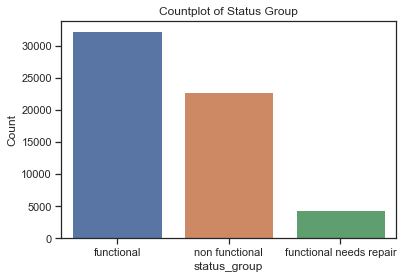

In [28]:
sns.set(style="ticks", color_codes=True)
ax = sns.countplot(train_joined["status_group"])
ax.set(ylabel='Count', 
       xlabel='status_group', 
       title='Countplot of Status Group')

#### FEATURE ENGINEERING

In [29]:
#change date_recorded column type to datetime
train_joined["date_recorded"] = pd.to_datetime(train_joined["date_recorded"])
test["date_recorded"] = pd.to_datetime(test["date_recorded"])

In [30]:
#add new column from date_recorded column
def new_col_date(df):
    df["year_record"] = df["date_recorded"].dt.year
    df["month_record"] = df["date_recorded"].dt.month

#apply
new_col_date(train_joined)
new_col_date(test)
    
#delete column
train_joined = train_joined.drop(columns = ["date_recorded"],
                                axis = 1)
test = test.drop(columns = ["date_recorded"],
                                axis = 1)

#### MODELLING

##### SPLIT TRAIN DATA

In [31]:
X = train_joined.drop(columns = ["status_group"],
                     axis = 1)
y = train_joined["status_group"]

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                 y,
                                                 test_size = 0.1,
                                                 random_state = 42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((53460, 33), (5940, 33), (53460,), (5940,))

##### PREPROCESSING

In [33]:
#for categorical columns
cat_pipeline = Pipeline([
    ('One Hot Encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [34]:
#for numerical columns
num_pipelines = Pipeline([
    ('Standard Scaler', StandardScaler())
])

In [35]:
#combine

#define num_features and obj_features
obj_features = X[X.dtypes[X.dtypes == "object"].index].columns
num_features = X[X.dtypes[X.dtypes != "object"].index].columns
print("object features :")
print(obj_features)
print("numerical features :")
print(num_features)

#preprocessing
preprocessor = ColumnTransformer(
    transformers = [
        ('Numerical', num_pipelines, num_features),
        ('Categorical', cat_pipeline, obj_features)  
    ],
    remainder = "drop"
)

object features :
Index(['basin', 'region', 'lga', 'ward', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')
numerical features :
Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'public_meeting',
       'permit', 'year_record', 'month_record'],
      dtype='object')


In [38]:
#fitting preprocessing pipeline
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep =  preprocessor.transform(X_val)

#checking shape
print ('X_train_prep.shape' , X_train_prep.shape)
print ('X_eval_prep.shape' , X_val_prep.shape)

X_train_prep.shape (53460, 2389)
X_eval_prep.shape (5940, 2389)


##### MODEL BUILDING

In [57]:
model = KNeighborsClassifier()
model.fit(X_train_prep, y_train)

KNeighborsClassifier()

In [58]:
predict_val = model.predict_val(X_val_prep)
predict_val

array(['non functional', 'functional', 'functional', ..., 'functional',
       'non functional', 'functional'], dtype=object)

In [59]:
#model accuracy
accuracy_score(y_val, predict_val)

0.7860269360269361

##### MODEL OPTIMIZING

KNeighborsClassifier

In [64]:
#define parameter for RandomForestClassifier
params = {'leaf_size':list(range(1,50)),
        'n_neighbors':list(range(1,30)),
        'algorithm' :['auto','ball_tree','kd_tree','brute'],
        'weights' : ['uniform','distance'],
        'p':[1, 2]
         }

knn = KNeighborsClassifier()

clf = RandomizedSearchCV(knn, 
                   params, 
                   scoring='accuracy', 
                   verbose=10,
                   cv = 5)
clf.fit(X_train_prep, y_train)

print(random_search.best_estimator_)
print(random_search.best_params_)
print(random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] weights=uniform, p=2, n_neighbors=17, leaf_size=33, algorithm=ball_tree 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  weights=uniform, p=2, n_neighbors=17, leaf_size=33, algorithm=ball_tree, score=0.765, total=  32.6s
[CV] weights=uniform, p=2, n_neighbors=17, leaf_size=33, algorithm=ball_tree 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.5s remaining:    0.0s


[CV]  weights=uniform, p=2, n_neighbors=17, leaf_size=33, algorithm=ball_tree, score=0.764, total=  33.5s
[CV] weights=uniform, p=2, n_neighbors=17, leaf_size=33, algorithm=ball_tree 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  weights=uniform, p=2, n_neighbors=17, leaf_size=33, algorithm=ball_tree, score=0.769, total=  31.1s
[CV] weights=uniform, p=2, n_neighbors=17, leaf_size=33, algorithm=ball_tree 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s


[CV]  weights=uniform, p=2, n_neighbors=17, leaf_size=33, algorithm=ball_tree, score=0.771, total=  31.0s
[CV] weights=uniform, p=2, n_neighbors=17, leaf_size=33, algorithm=ball_tree 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s


[CV]  weights=uniform, p=2, n_neighbors=17, leaf_size=33, algorithm=ball_tree, score=0.763, total=  31.6s
[CV] weights=uniform, p=1, n_neighbors=6, leaf_size=32, algorithm=brute 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s


[CV]  weights=uniform, p=1, n_neighbors=6, leaf_size=32, algorithm=brute, score=0.775, total=  17.7s
[CV] weights=uniform, p=1, n_neighbors=6, leaf_size=32, algorithm=brute 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.0min remaining:    0.0s


[CV]  weights=uniform, p=1, n_neighbors=6, leaf_size=32, algorithm=brute, score=0.782, total=  17.7s
[CV] weights=uniform, p=1, n_neighbors=6, leaf_size=32, algorithm=brute 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.2min remaining:    0.0s


[CV]  weights=uniform, p=1, n_neighbors=6, leaf_size=32, algorithm=brute, score=0.783, total=  18.1s
[CV] weights=uniform, p=1, n_neighbors=6, leaf_size=32, algorithm=brute 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.6min remaining:    0.0s


[CV]  weights=uniform, p=1, n_neighbors=6, leaf_size=32, algorithm=brute, score=0.786, total=  18.8s
[CV] weights=uniform, p=1, n_neighbors=6, leaf_size=32, algorithm=brute 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.9min remaining:    0.0s


[CV]  weights=uniform, p=1, n_neighbors=6, leaf_size=32, algorithm=brute, score=0.784, total=  18.1s
[CV] weights=uniform, p=1, n_neighbors=7, leaf_size=24, algorithm=ball_tree 
[CV]  weights=uniform, p=1, n_neighbors=7, leaf_size=24, algorithm=ball_tree, score=0.776, total=  17.8s
[CV] weights=uniform, p=1, n_neighbors=7, leaf_size=24, algorithm=ball_tree 
[CV]  weights=uniform, p=1, n_neighbors=7, leaf_size=24, algorithm=ball_tree, score=0.781, total=  18.0s
[CV] weights=uniform, p=1, n_neighbors=7, leaf_size=24, algorithm=ball_tree 
[CV]  weights=uniform, p=1, n_neighbors=7, leaf_size=24, algorithm=ball_tree, score=0.782, total=  18.0s
[CV] weights=uniform, p=1, n_neighbors=7, leaf_size=24, algorithm=ball_tree 
[CV]  weights=uniform, p=1, n_neighbors=7, leaf_size=24, algorithm=ball_tree, score=0.788, total=  18.3s
[CV] weights=uniform, p=1, n_neighbors=7, leaf_size=24, algorithm=ball_tree 
[CV]  weights=uniform, p=1, n_neighbors=7, leaf_size=24, algorithm=ball_tree, score=0.781, tot

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 18.1min finished


In [69]:
model_opt = KNeighborsClassifier(weights="distance", 
                                p=1, 
                                n_neighbors=14, 
                                leaf_size=44, 
                                algorithm="auto")
model_opt.fit(X_train_prep, y_train)

KNeighborsClassifier(leaf_size=44, n_neighbors=14, p=1, weights='distance')

In [70]:
#predicting validation data with optimized knn model
opt_val = model_opt.predict(X_val_prep)

#optimized model accuracy
accuracy_score(y_val, opt_val)

0.794949494949495

RandomForestClassifier

In [74]:
#define parameter for RandomForestClassifier
params = {'n_estimators':[2, 5, 10, 20, 50, 75, 150],
        'criterion':['gini', 'entropy'],
        'max_depth':[2, 5, 10, 20, 50, None],
        'min_samples_split':[2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False],
        'max_features': ['auto', 'sqrt'],
         }

rf = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=rf, 
                                   param_distributions=params, 
                                   scoring='accuracy', 
                                   verbose=10,
                                   cv = 5)
random_search.fit(X_train_prep, y_train)

print(random_search.best_estimator_)
print(random_search.best_params_)
print(random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, criterion=gini, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, criterion=gini, bootstrap=True, score=0.788, total=   7.2s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, criterion=gini, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, criterion=gini, bootstrap=True, score=0.790, total=   6.7s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, criterion=gini, bootstrap=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.8s remaining:    0.0s


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, criterion=gini, bootstrap=True, score=0.794, total=   6.8s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, criterion=gini, bootstrap=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.6s remaining:    0.0s


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, criterion=gini, bootstrap=True, score=0.796, total=   6.8s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, criterion=gini, bootstrap=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.4s remaining:    0.0s


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, criterion=gini, bootstrap=True, score=0.788, total=   6.8s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=True 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.2s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=True, score=0.723, total=   2.7s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=True 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   36.9s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=True, score=0.723, total=   2.4s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=True 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   39.3s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=True, score=0.730, total=   2.4s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=True 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   41.6s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=True, score=0.732, total=   2.3s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=True 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   43.9s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=True, score=0.724, total=   2.3s
[CV] n_estimators=75, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=entropy, bootstrap=True 
[CV]  n_estimators=75, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=entropy, bootstrap=True, score=0.771, total=  13.5s
[CV] n_estimators=75, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=entropy, bootstrap=True 
[CV]  n_estimators=75, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=entropy, bootstrap=True, score=0.774, total=  13.3s
[CV] n_estimators=75, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=entropy, bootstrap=True 
[CV]  n_estimators=75, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=entro

[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=2, criterion=entropy, bootstrap=False, score=0.620, total=   0.5s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=2, criterion=entropy, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=2, criterion=entropy, bootstrap=False, score=0.607, total=   0.6s
[CV] n_estimators=75, min_samples_split=20, min_samples_leaf=1, max_features=auto, max_depth=50, criterion=gini, bootstrap=False 
[CV]  n_estimators=75, min_samples_split=20, min_samples_leaf=1, max_features=auto, max_depth=50, criterion=gini, bootstrap=False, score=0.799, total=  38.8s
[CV] n_estimators=75, min_samples_split=20, min_samples_leaf=1, max_features=auto, max_depth=50, criterion=gini, bootstrap=False 
[CV]  n_estimators=75, min_samples_split=20, min_samples_leaf=1, max_features=auto, max_depth=50, criterion=gini, bootstrap=False, sc

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.3min finished


RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_split=20,
                       n_estimators=75)
{'n_estimators': 75, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'gini', 'bootstrap': False}
0.8049008604564161


In [75]:
#predicting validation data with optimized rf model
rf_val = random_search.predict(X_val_prep)

#optimized model accuracy
accuracy_score(y_val, rf_val)

0.8087542087542088

#### PREDICT TEST DATA

In [71]:
#preprocessing test data
X_test_prep = preprocessor.transform(test)

In [76]:
#predict test data
model_predict = random_search.predict(X_test_prep)
model_predict

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

#### SUBMISSION

In [77]:
SubmissionFormat["status_group"] = model_predict
SubmissionFormat.to_csv('data_mining_water_table.csv',index=False)
SubmissionFormat

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional
